In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/Users/lzung/opt/miniconda3/envs/573/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predicting heart failures: Supporting clinical decisions for the health and wellness of cardiovascular disease patients

## Problem Overview

[Heart failure](https://www.uchealth.com/en/conditions/heart-failure) is a progressive condition where the heart muscle gradually loses its ability to pump blood throughout the body. As the current leading cause of death worldwide, cardiovascular diseases (CVDs) account for over [$20
billion direct and indirect costs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2722492/#:~:text=CVD%20was%20also%20the%20most,and%20physician%20care%20for%2012%25.) for the Canadian healthcare system each year. With no known cure for CVD, patients often require complex treatments to manage the condition.

However, CVDs are preventable in their early stages. Individuals can interfere with its progression by controlling certain risk factors once it is identified by their healthcare provider. By analyzing clinical data, I hope to better identify individuals who are at risk of heart failure using machine learning. Its predictions could lend support to healthcare providers by reinforcing early detection and intervention strategies.

The goal of this analysis is to predict whether a patient will die from heart failure or survive, based on demographics such as their age or sex and various lab test results. My model outputs predictions for the `DEATH_EVENT` column: 0 means that the patient survived and 1 means that they died. The data is sourced from the 'Heart Failure Prediction' dataset on [Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data).

## Exploratory Data Analysis
First, I split the data into two sets with 75% assigned for training and 25% for testing my model. I separated each set into two groups: X = columns containing values I will use to predict and y = column I am trying to predict.

In [2]:
hf_df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')
hf_train, hf_test = train_test_split(hf_df, random_state=123)

X_train = hf_train.drop(columns=['DEATH_EVENT'])
y_train = hf_train['DEATH_EVENT']

X_test = hf_test.drop(columns=['DEATH_EVENT'])
y_test = hf_test['DEATH_EVENT']

hf_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
107,45.0,1,1876,1,35,0,226000.0,0.9,138,1,0,88,0
5,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
206,40.0,1,101,0,40,0,226000.0,0.8,141,0,0,187,0
276,70.0,0,618,0,35,0,327000.0,1.1,142,0,0,245,0
258,45.0,1,66,1,25,0,233000.0,0.8,135,1,0,230,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,55.0,0,748,0,45,0,263000.0,1.3,137,1,0,88,0
83,79.0,1,55,0,50,1,172000.0,1.8,133,1,0,78,0
17,45.0,0,582,0,14,0,166000.0,0.8,127,1,0,14,1
230,60.0,0,166,0,30,0,62000.0,1.7,127,0,0,207,1


The dataset consists of 13 feature columns with 6 containing only 0 or 1 as a value. 1 represents the presence of a condition and 0 represents the absence. For the `sex` column, 0 is female and 1 is male. For the `smoking` column, 0 indicates a non-smoker and 1 is for smokers. `time` is the patient's follow-up period in days.

Furthermore, there is a large range of values for the `creatinine_phosphokinase`, `platelets` and `serum_creatinine` columns.

In [3]:
hf_train.describe().loc[['min', 'max'], :]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
min,40.0,0.0,47.0,0.0,14.0,0.0,47000.0,0.5,113.0,0.0,0.0,4.0,0.0
max,95.0,1.0,7861.0,1.0,80.0,1.0,850000.0,9.4,145.0,1.0,1.0,285.0,1.0


I decided not to drop any patients from the dataset, even though the extreme values could be considered 'outliers'. This was because:
1) Amount of accessible data is very limited (< 300 samples); should ideally keep as much as possible
2) Clinical values have been shown to fluctuate depending on the individual based on their [race and sex](https://www.portea.com/labs/diagnostic-tests/creatine-phosphokinase-cpk-ck-mb-bb-mm-83/#:~:text=CPK%20blood%20tests%20the%20different,26%20%E2%80%93%20192%20U%2FL)
3) **Values that are inflated or deflated above normal range could be indicative of clinical disease and are not uncommon to observe in medical practice**

I have highlighted this principle using the figure below:

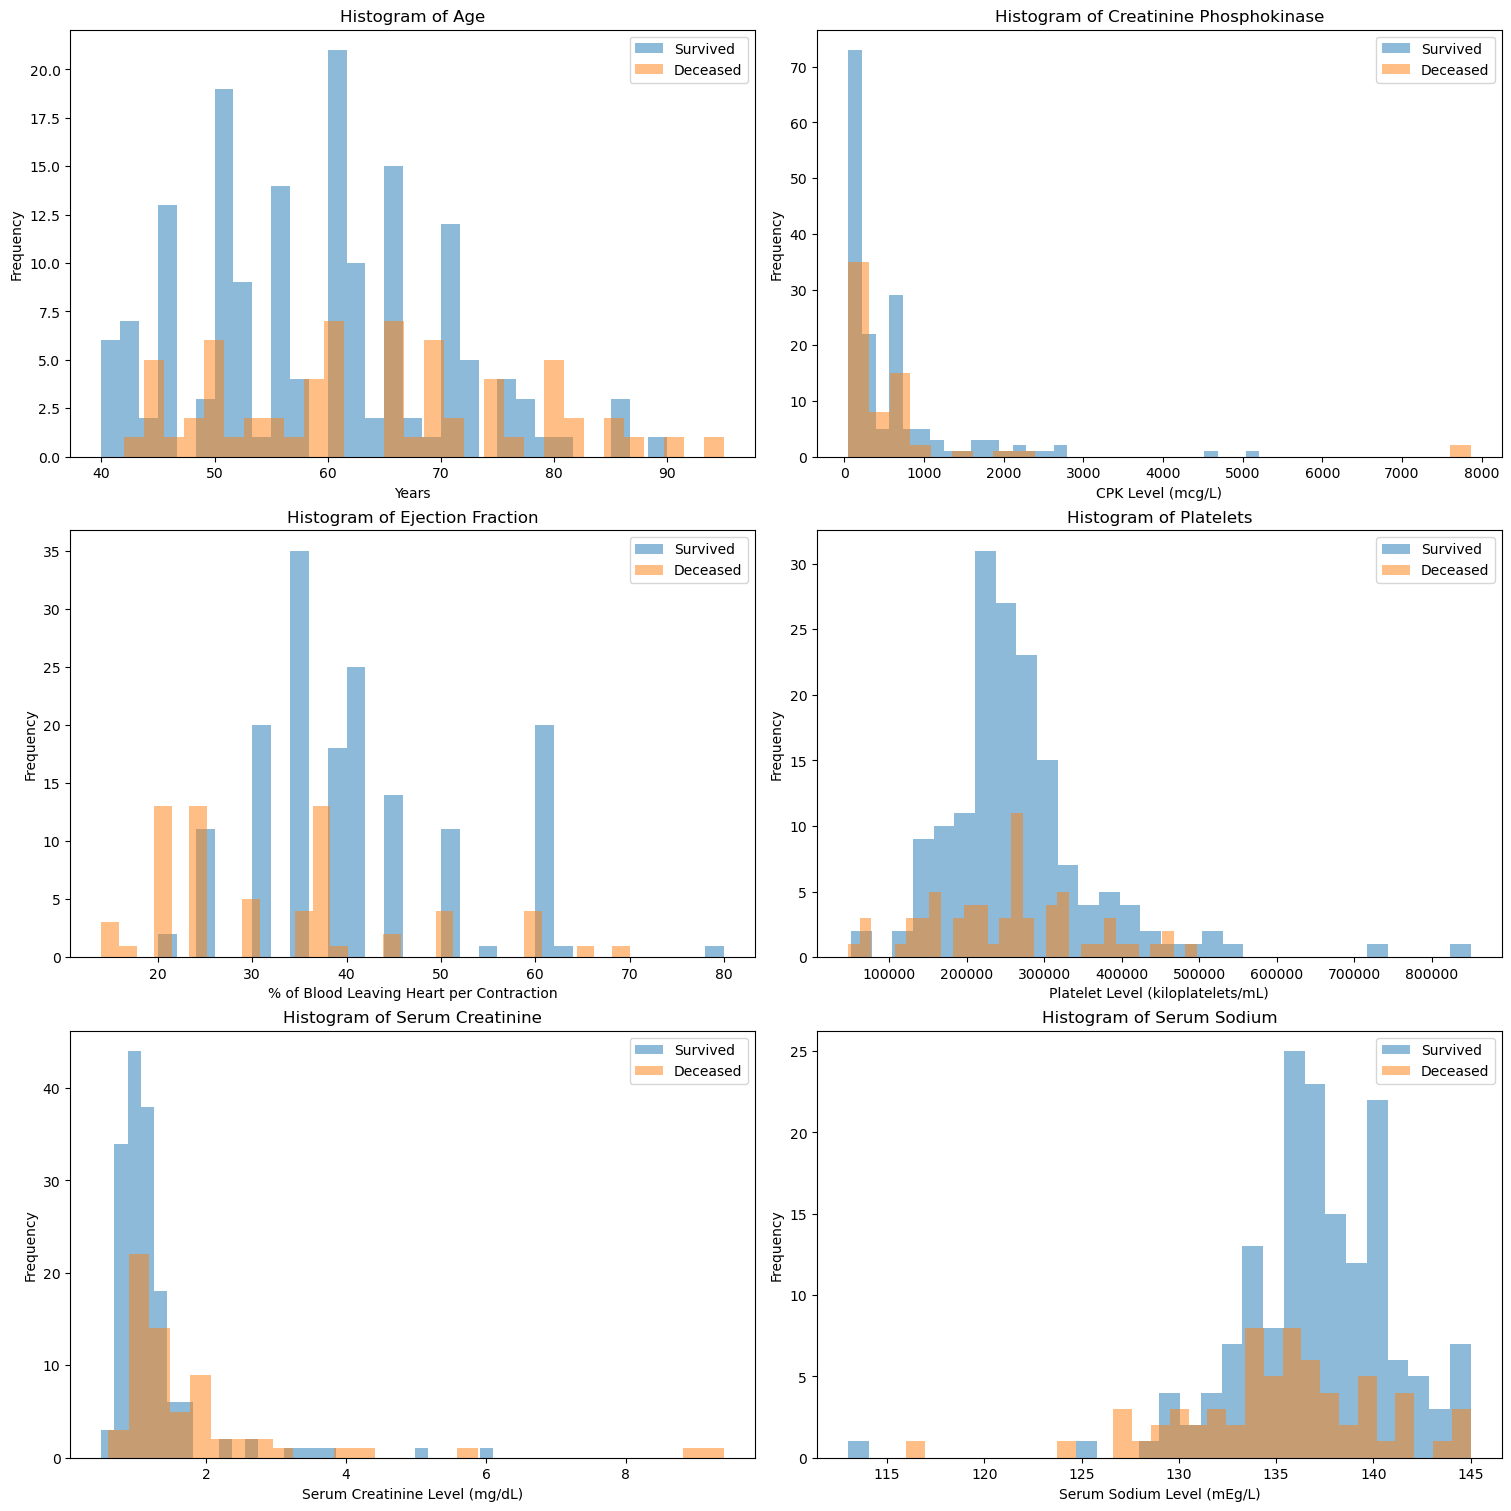

In [4]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
data = [hf_train.age, hf_train.creatinine_phosphokinase, hf_train.ejection_fraction,
        hf_train.platelets, hf_train.serum_creatinine, hf_train.serum_sodium]
titles = ['Age', 'Creatinine Phosphokinase', 'Ejection Fraction', 'Platelets',
          'Serum Creatinine', 'Serum Sodium']
xlabels = ['Years', 'CPK Level (mcg/L)', '% of Blood Leaving Heart per Contraction',
           'Platelet Level (kiloplatelets/mL)', 'Serum Creatinine Level (mg/dL)',
           'Serum Sodium Level (mEg/L)']

for n in range(len(axs)):
    axs[n].hist(data[n].loc[hf_train['DEATH_EVENT'] == 0], bins=30, alpha=0.5, label='Survived')
    axs[n].hist(data[n].loc[hf_train['DEATH_EVENT'] == 1], bins=30, alpha=0.5, label='Deceased')
    axs[n].set_title('Histogram of ' + titles[n])
    axs[n].set_xlabel(xlabels[n])
    axs[n].set_ylabel('Frequency')
    axs[n].legend(loc='upper right')
plt.show()

Generally, there are equal proportions of patients who survive or die from heart disease outside of the average range for each feature. Since every person in the dataset was assessed in-hospital and had lab work conducted, I assumed that these values would be observed in the typical population that is screened for CVD and thus, my model should be able to address them.

## Preprocessing
I sorted columns into two groups: binary (those with only 0 or 1) and numeric. Missing values in binary columns would be replaced by the most frequent value of the column. Missing values in numeric columns would be replaced by the median. These were also scaled to be roughly proportional to each other. This prevents large values from having a greater impact on the model's performance just from being bigger than others, rather than because of a relevant connection to `DEATH_EVENT`.

The `time` column was also dropped. If we want to predict outcomes for patients who have just been assessed by their healthcare provider, we would not know the total days for their follow-up period during recovery and the model would be missing information that is necessary for predictions if included.

In [5]:
numeric_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
                    'serum_creatinine', 'serum_sodium']
binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
target_column = 'DEATH_EVENT'
drop_features = 'time' # this will be dropped automatically in the process

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('binary', binary_transformer, binary_features),
    ('numeric', numeric_transformer, numeric_features)
])

preprocessor.fit(hf_train);

## LogisticRegression: With vs Without Class Balancing
I trained a LogisiticRegression (LR) model to generate the predictions. From the LR coefficients, we can identify features that are most significant in predicting heart failure:

In [6]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr_pipe.fit(X_train, y_train);
weight_df = pd.DataFrame(data=lr_pipe[1].coef_.ravel(), index=(numeric_features+binary_features), columns=['Coefficient'])
weight_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
serum_sodium,0.571930
sex,0.507303
age,0.234579
ejection_fraction,0.215911
anaemia,0.193029
creatinine_phosphokinase,0.010814
high_blood_pressure,-0.052601
platelets,-0.054053
smoking,-0.140721
serum_creatinine,-0.345537


A higher level of serum sodium in the blood seems to increase the predicted probability that the patient will die of heart failure. In contrast, the model interpretted that someone will have a lower predicted probability of dying if they have diabetes (i.e. they are more likely to survive; more on this later).

It is important to note that only 65 of the patients in the training set died while 159 survived. For this problem, I want to intervene especially for people who are at risk, even if it means offering more treatments to patients who may actually survive. Thus, it is better to have a **high recall** or increased true positive (TP) rate. Because there are comparatively fewer cases in the data, the model does not do a great job at predicting deaths and instead places more value on correctly identifying the patients who survived. To counteract this, I weighed false negatives as being 3 times more problematic than false positives because there is roughly 2.5 times more instances of class 0 in the target column compared to 1.

In [7]:
lr_pipe_balanced = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight={1:3}))
lr_pipe_balanced.fit(X_train, y_train);

This increased the model's likelihood of predicting that a patient will die by making class 1 more important. We can observe this change by looking at the differences between each LR variations' confusion matrix:

/Users/lzung/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/lzung/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


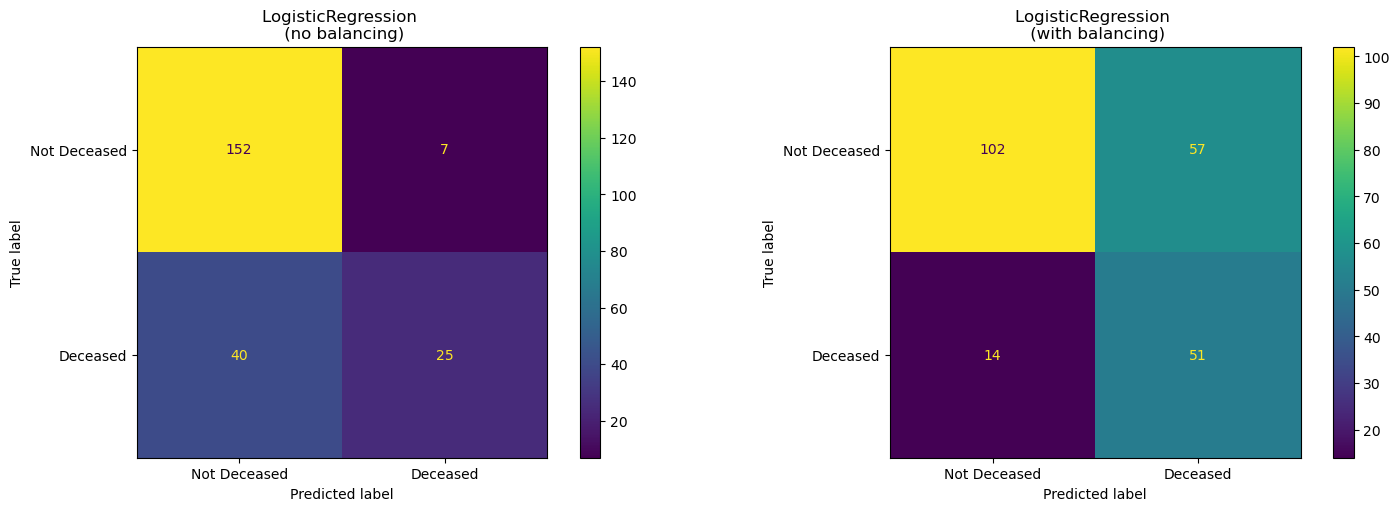

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5), constrained_layout=True)
plot_confusion_matrix(lr_pipe, X_train, y_train, display_labels=['Not Deceased', 'Deceased'], ax=ax1)
ax1.set_title('LogisticRegression \n (no balancing)')
plot_confusion_matrix(lr_pipe_balanced, X_train, y_train, display_labels=['Not Deceased', 'Deceased'], ax=ax2)
ax2.set_title('LogisticRegression \n (with balancing)')
plt.show()

The LR without balancing only caught 25/65 deceased cases, whereas the LR with balancing correctly identified 51. Comparatively, the unbalanced LR more accurately detected cases that survived (152/159) and the balanced LR incorrectly predicted 57 cases as deceased when the patient actually survives. The balance between the true and false positive (FP) rates is also easily visualized on an ROC curve for the LR.

/Users/lzung/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


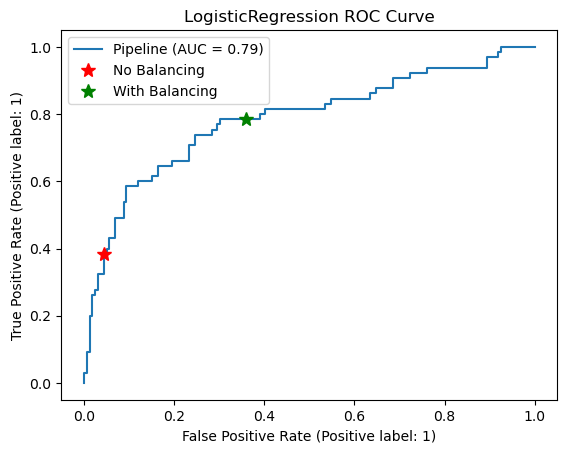

In [9]:
cm_lr = confusion_matrix(y_train, lr_pipe.predict(X_train))
cm_lrb = confusion_matrix(y_train, lr_pipe_balanced.predict(X_train))
plot_roc_curve(lr_pipe, X_train, y_train);
plt.plot(cm_lr[0,1]/(cm_lr[0].sum()), cm_lr[1,1]/(cm_lr[1].sum()), '*r', markersize=10, label='No Balancing');
plt.plot(cm_lrb[0,1]/(cm_lrb[0].sum()), cm_lrb[1,1]/(cm_lrb[1].sum()), '*g', markersize=10, label='With Balancing');
plt.title('LogisticRegression ROC Curve')
plt.legend()
plt.show()

While the unbalanced LR keeps the FP rate relatively low (red star, <10%), it also ends up with a fairly low TP rate (~ 40%). The balanced LR increases both (~ 80% TP and <40% FP rates), which is preferred since we want a high TP rate without severely overestimating the number of deceased cases. Therefore, adjusting the class weights produces better results for this task.

Attempting to further improve the model, I used RandomizedSearchCV to optimize the hyperparameter C used by LR. This assessed 10 different LR models with unique values of C to identify the one that produces the best results, which in this case is the highest average F1 score over 5 cross-validation folds. I chose to optimize F1 score as it captures both the precision (how many predicted deaths are actual deaths) and recall scores, and is generally perceived as a good evaluation metric when there is a class imbalance in the data.

In [10]:
lr_param_grid = {
    "logisticregression__C" : 2.0**np.arange(-5,5)
}
lrbcv = RandomizedSearchCV(lr_pipe_balanced, lr_param_grid, scoring='f1_micro', n_jobs=-1)
lrbcv.fit(X_train, y_train);

In [11]:
print(f"The best C value for the LogisticRegression model is {lrbcv.best_params_['logisticregression__C']}.")
print(f"The F1 score produced by the best LogisticRegression model is {lrbcv.best_score_:.2f}.")

The best C value for the LogisticRegression model is 0.25.
The F1 score produced by the best LogisticRegression model is 0.62.


To summarize, the best and final LogisticRegression model for this problem has each class reweighted at 1 to 3 for 0 (survived) and 1 (died of heart failure) respectively, as well as a C value of 0.25. The average F1 validation score produced by this classifier is 0.62.

## Results - Model Comparison
To determine whether the class weights had an effect on model performance, I compiled the F1 training, F1 validation and recall scores for LR with and without class balancing. We can also observe the effectiveness of the hyperparameter tuning after balancing by contrasting against the prior two models.

In [12]:
models = [lr_pipe, lr_pipe_balanced, lrbcv.best_estimator_]

avg_train_score = []
avg_val_score = []
recall = []

for m in models:
    results = cross_validate(m, X_train, y_train, scoring='f1_micro', return_train_score=True)
    avg_train_score.append(round(results['train_score'].mean(), 2))
    avg_val_score.append(round(results['test_score'].mean(), 2))
    recall.append(round(recall_score(y_train, m.predict(X_train)), 2))

pd.DataFrame(list(zip(avg_train_score, avg_val_score, recall)),
             index=['Without Balancing', 'With Balancing', 'After Tuning'],
             columns=['Average Training Score', 'Average Validation Score', 'Recall Score'])


,Average Training Score,Average Validation Score,Recall Score
Without Balancing,0.79,0.74,0.38
With Balancing,0.69,0.59,0.78
After Tuning,0.68,0.62,0.78


The average F1 train and validation scores both drop after the class balance is employed. However, 78% of heart failure deaths are caught by the class-balanced LR as indicated by the increase in recall score by 40%. This is an improvement as it is preferrable to overestimate possible deaths rather than miss over half.

After tuning, the F1 training score goes down by 0.01 but it ends up producing a higher average F1 validation score compared to the balanced LR with the default C value. This is somewhat representative of how the model performs on unseen data and therefore, the hyperparameter tuning was successful. It is still producing lower train and validation scores than the unbalanced LR, but this model maintains the more ideal higher recall score.

In [13]:
print(f"Recall test score = {recall_score(y_test, lrbcv.best_estimator_.predict(X_test)):.2f}")
print(f"F1 test score = {f1_score(y_test, lrbcv.best_estimator_.predict(X_test), average='micro'):.2f}")

Recall test score = 0.84
F1 test score = 0.72


With a 0.72 F1 score and 84% recall, these results are surprisingly higher than the scores received using the training set. The confusion matrix below captures the LR's ability to identify 'Deceased' cases in the test set. These findings show that the model may adequately predict heart failure deaths for new patients! However, it should be noted that the test set only contains 75 samples and thus, these values may be overly optimistic of how good the model will operate in deployment.

/Users/lzung/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


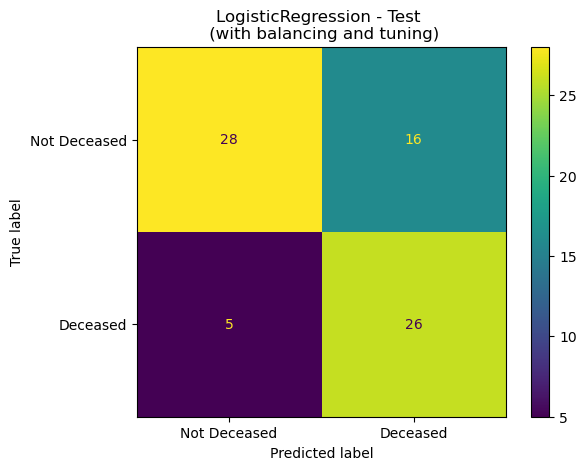

In [14]:
plot_confusion_matrix(lrbcv.best_estimator_, X_test, y_test, display_labels=['Not Deceased', 'Deceased'])
plt.title('LogisticRegression - Test \n (with balancing and tuning)');

## Short-comings and Future Plans
The major downfall of this analysis is the size of the dataset. With only 224 samples to train on, the lack of data likely contributed to the model's unusual coefficients, implying that patients with diabetes are more likely to survive even though the literature states that it is [comorbid with CVD](https://spectrum.diabetesjournals.org/content/21/3/160). Risk factors such as high blood pressure and smoking should increase susceptibility to dying from heart failure, however the LR suggests that these features decrease a patient's likelihood of mortality. While the model does a reasonable job at predicting heart failure deaths here, I would expect it to perform more poorly on a different hospital population because of its misinterpretations of input features.

As a result of the class imbalance, the model initially missed many death cases as it was biased towards the 0 class given its proportion in the dataset. I accounted for the low recall by manually making false negatives more problematic based on the 0:1 class ratio, but this lowered the precision to 47%; more than half of the patients who are predicted to die actually survive. This may be problematic if we consider the cost of wasted CVD treatments.

By optimizing F1 score and favouring recall, we compromise the overall accuracy of the LR model. Since this problem cares most about detecting deaths, it is nearly impossible to identify a large number of patients at risk of heart failure and achieve a 80-90% accuracy with the data provided. The model will only be appropriately used in cases where death avoidance is a priority, and not if isolating survivors is required.